In [2]:
# Imports
import os
import pickle as pkl
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Imputation
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.ensemble import ExtraTreesRegressor

In [4]:
## GLOBAL VARIABLES
RAND_STATE = 0

In [5]:
# Import data
TRAIN_RPATH = os.path.join("cs5228", "train.csv")
TEST_RPATH = os.path.join("cs5228", "test.csv")

# Raw data
data_alltrain = pd.read_csv(TRAIN_RPATH, skipinitialspace=True)
data_test = pd.read_csv(TEST_RPATH, skipinitialspace=True)

# Separate data from labels
y_alltrain = data_alltrain.exceeds50K
raw_alltrain = data_alltrain.drop(["exceeds50K"], axis=1, inplace=False)

In [6]:
print(data_alltrain.shape)
print(data_test.shape)
print(y_alltrain.value_counts())

(24421, 14)
(24421, 13)
0    18560
1     5861
Name: exceeds50K, dtype: int64


### Combining training and test set
* Do not remove any rows (e.g. duplicated, missing values) in test set

In [7]:
# Combine both train and test data before performing one-hot encoding!
# Train data does not contain Holand-Netherlands factor!
# Combine data to facilitate preprocessing
combined_data = raw_alltrain.append(data_test)
idx = pd.Series(["train","test"]).repeat(
    [raw_alltrain.shape[0], data_test.shape[0]])
combined_data.set_index([idx, combined_data.index], inplace=True)

In [87]:
# ## CANNOT REMOVE DUPLICATED ROWS IN TEST SET!
# ## Test data: Duplicated rows
# print("No. of duplicated rows in test set:",
#       data_test[data_test.duplicated(keep=False)].shape[0])
# print(data_test[data_test.duplicated(keep=False)])

# Train data has duplicated rows
# print(raw_alltrain[raw_alltrain.duplicated(keep=False)])

### Inspection of missing values

In [6]:
### NAN VALUES
combined_data.replace('?', np.nan, inplace=True)
combined_data.isna().sum(axis=0)

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

In [57]:
print(np.unique(data_alltrain.workclass))
print(np.unique(data_alltrain.occupation))

['?' 'Federal-gov' 'Local-gov' 'Never-worked' 'Private' 'Self-emp-inc'
 'Self-emp-not-inc' 'State-gov' 'Without-pay']
['?' 'Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transport-moving']


In [31]:
combined_data.groupby(["workclass", "occupation"]).size().unstack()

occupation,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
workclass,,,,,,,,,,,,,,
Federal-gov,487.0,15.0,93.0,268.0,9.0,36.0,19.0,55.0,NaN,253.0,47.0,17.0,96.0,37.0
Local-gov,421.0,NaN,211.0,331.0,43.0,65.0,24.0,300.0,NaN,1061.0,450.0,16.0,58.0,156.0
Private,4208.0,NaN,4748.0,3995.0,670.0,1923.0,2882.0,4057.0,242.0,3409.0,299.0,4439.0,1154.0,1880.0
Self-emp-inc,47.0,NaN,167.0,617.0,82.0,6.0,17.0,42.0,NaN,245.0,5.0,420.0,9.0,38.0
Self-emp-not-inc,70.0,NaN,798.0,587.0,653.0,21.0,59.0,276.0,NaN,575.0,7.0,591.0,42.0,183.0
State-gov,375.0,NaN,94.0,287.0,25.0,19.0,19.0,191.0,NaN,629.0,175.0,20.0,87.0,60.0
Without-pay,3.0,NaN,1.0,1.0,8.0,2.0,2.0,2.0,NaN,NaN,NaN,1.0,NaN,1.0


#### Imputation

In [41]:
## OPTION 1: Replace all NaNs with category 'Others'
imputed_data = combined_data.fillna("Others")

In [30]:
## OPTION 2: Replaced NaNs in occupation with category 'Others'
combined_data.occupation = combined_data.occupation.fillna("Others")

## Impute native-country and workclass with most frequent value
simple_imputer = SimpleImputer(strategy="most_frequent")
imputed_data = pd.DataFrame(simple_imputer.fit_transform(combined_data),
                            index=combined_data.index,
                            columns=list(combined_data))
imputed_data1 = imputed_data.astype(combined_data.dtypes)
print(imputed_data1.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 48842 entries, ('train', 0) to ('test', 24420)
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   sex             48842 non-null  object
 9   capital-gain    48842 non-null  int64 
 10  capital-loss    48842 non-null  int64 
 11  hours-per-week  48842 non-null  int64 
 12  native-country  48842 non-null  object
dtypes: int64(6), object(7)
memory usage: 5.2+ MB
None


### Feature selection

In [8]:
## OPTION 1 (NO REPLACING NANs)
## Combine attributes capital-gain and capital-loss into one attribute
combined_data['net_capital_gain'] = combined_data["capital-gain"] - combined_data["capital-loss"]
selected_data = combined_data.drop(["capital-gain","capital-loss"], axis=1)

In [31]:
## OPTION 2
## Combine attributes capital-gain and capital-loss into one attribute
imputed_data1['net_capital_gain'] = imputed_data1["capital-gain"] - imputed_data1["capital-loss"]
selected_data = imputed_data1.drop(["capital-gain","capital-loss"], axis=1)

In [32]:
## Removing features
selected_data = selected_data.drop(['education', 'fnlwgt'], axis=1)

In [36]:
## Reordering numerical and categorical columns
imputed_data.fnlwgt = imputed_data.fnlwgt.astype('str')
idx = imputed_data.dtypes == 'object'
cat_features = imputed_data.columns.values[idx]
num_features = imputed_data.columns.values[~idx]
all_features = np.concatenate([num_features, cat_features])
reordered_data = imputed_data.loc[:,all_features]
reordered_data.head()

age  education-num  capital-gain  capital-loss  hours-per-week  \
train 0   30             10             0             0              30   
      1   60             13             0             0              42   
      2   52             10             0             0              12   
      3   37             13             0             0              60   
      4   63             10          7298             0              48   

        workclass  fnlwgt     education      marital-status      occupation  \
train 0    Others  147215  Some-college       Never-married          Others   
      1   Private  173960     Bachelors            Divorced  Prof-specialty   
      2    Others  105428  Some-college  Married-civ-spouse          Others   
      3   Private  112497     Bachelors  Married-civ-spouse           Sales   
      4   Private  137843  Some-college  Married-civ-spouse           Sales   

          relationship     sex native-country  
train 0      Own-child  Female  United-States  
      1  Not-in-family  Female  United-States  
      2        Husband    Male  United-States  
      3        Husband    Male  United-States  
      4        Husband    Male  United-States

In [37]:
## SAVE DATA
reordered_alltrain = reordered_data.loc["train",:]
reordered_test = reordered_data.loc["test",:]

DATA_WPATH = "dump/data/raw1c.pkl"
with open(DATA_WPATH, "wb") as f:
    pkl.dump([reordered_alltrain, y_alltrain, reordered_test], f)

### Feature encoding

In [11]:
## ONE-HOT ENCODING
# NaN values for categorical variables are treated as all zeros!!!
onehotenc_data = pd.get_dummies(selected_data)

# # Check encoding of NaN
# print(data_test.loc[data_test.isnull().sum(axis=1) > 0,:])

In [202]:
## LABEL ENCODING
idx = selected_data.dtypes == "object"
cat_features = selected_data.columns.values[idx]
num_features = selected_data.columns.values[~idx]
all_features = np.concatenate([cat_features, num_features])

col_transform = ColumnTransformer(
    transformers=[('cat', OrdinalEncoder(), cat_features)],
    remainder='passthrough')
ordenc_data = pd.DataFrame(col_transform.fit_transform(selected_data),
                           index=selected_data.index,
                           columns=all_features).astype("int")

In [54]:
## SAVE DATA
onehotenc_alltrain = onehotenc_data.loc["train",:]
onehotenc_test = onehotenc_data.loc["test",:]
print(onehotenc_alltrain.shape)
print(y_alltrain.shape)
print(onehotenc_test.shape)
print(list(onehotenc_test))

DATA_WPATH = "dump/data/wxpp1c.pkl"
with open(DATA_WPATH, "wb") as f:
    pkl.dump([onehotenc_alltrain, y_alltrain, onehotenc_test], f)

(24421, 42)
(24421,)
(24421, 42)
['age', 'education-num', 'hours-per-week', 'net_capital_gain', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'marital-status_Divorced', 'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct', 'occupation_Other-service', 'occupation_Others', 'occupation_Priv-house-serv', 'occupation_Prof-specialty', 'occupation_Protective-serv', 'occupation_Sales', 'occupation_Tech-support', 'occupation_Transport-moving', 'relationship_Husband', 'relationship_Not-in-family', 'rel

### Feature transformation

In [34]:
## SCALING OF NUMERICAL VARIABLES
idx = selected_data.dtypes == "object"

cat_combined = selected_data.loc[:,idx]
num_alltrain = selected_data.loc["train", ~idx]
num_test = selected_data.loc["test", ~idx]

scaler = StandardScaler()
scaled_alltrain = pd.DataFrame(scaler.fit_transform(num_alltrain),
                               index=num_alltrain.index,
                               columns=list(num_alltrain))
scaled_test = pd.DataFrame(scaler.transform(num_test),
                           index=num_test.index,
                           columns=list(num_test))
scaled_combined = pd.concat([scaled_alltrain, scaled_test], axis=0,
                           keys=["train","test"])
scaled_data = pd.concat([scaled_combined, cat_combined], axis=1)

## ONE-HOT ENCODING
# NaN values for categorical variables are treated as all zeros!!!
scaled_onehotenc = pd.get_dummies(scaled_data)

scaled_onehotenc_alltrain = scaled_onehotenc.loc["train",:]
scaled_onehotenc_test = scaled_onehotenc.loc["test",:]

scaled_onehotenc_alltrain.head()

,age,education-num,hours-per-week,net_capital_gain,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,-0.627855,-0.037490,-0.849954,-0.134232,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.565644,1.127814,0.120349,-0.134232,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.980711,-0.037490,-2.305408,-0.134232,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,-0.116039,1.127814,1.575803,-0.134232,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1.784994,-0.037490,0.605501,0.817336,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [206]:
## Discretise features
ordenc_binned_data = ordenc_data.copy(deep=True)

age_bins = list(range(15,105,10))
bin_age = pd.cut(ordenc_data.age,
                 bins=age_bins, labels=False)
ordenc_binned_data.age = bin_age

hr_bins = list(range(0,110,10))
bin_hr = pd.cut(ordenc_data['hours-per-week'],
                bins=hr_bins, labels=False)
ordenc_binned_data['hours-per-week'] = bin_hr

# Assumption: net_capital_gain falls within -10K and 120K
capgain_bins = np.array([-10,-5,-1,1,2,5,10,15,20,50,120]) * 1000
print(capgain_bins)
bin_capgain = pd.cut(ordenc_data['net_capital_gain'],
                     bins=capgain_bins, labels=False)
ordenc_binned_data['net_capital_gain'] = bin_capgain

[-10000  -5000  -1000   1000   2000   5000  10000  15000  20000  50000
 120000]


In [3]:
age_bins = list(range(15,105,10))
hr_bins = list(range(0,110,10))
capgain_bins = np.array([-10,-5,-1,1,2,5,10,15,20,50,120]) * 1000
print(age_bins)
print(hr_bins)
print(capgain_bins)

[15, 25, 35, 45, 55, 65, 75, 85, 95]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[-10000  -5000  -1000   1000   2000   5000  10000  15000  20000  50000
 120000]


In [208]:
## SAVE DATA
ordenc_binned_alltrain = ordenc_binned_data.loc["train",:]
ordenc_binned_test = ordenc_binned_data.loc["test",:]
print(ordenc_binned_alltrain.shape)
print(ordenc_binned_test.shape)

DATA_WPATH = "dump/data/allcat.pkl"
with open(DATA_WPATH, "wb") as f:
    pkl.dump([ordenc_binned_alltrain, y_alltrain, ordenc_binned_test], f)

(24421, 9)
(24421, 9)


### Data exploration

In [4]:
## IMPORT DATA
TRAIN_RPATH = "dump/data/labelenc.pkl"
with open(TRAIN_RPATH, "rb") as f:
    labelenc_alltrain, y_alltrain, labelenc_test = pkl.load(f)
    
print(labelenc_alltrain.shape)
print(y_alltrain.shape)
print(labelenc_test.shape)
labelenc_alltrain

(24421, 11)
(24421,)
(24421, 11)


,age,education-num,hours-per-week,net_capital_gain,workclass,fnlwgt,marital-status,occupation,relationship,sex,native-country
0,30,10,30,0,3,4834,4,8,3,0,39
1,60,13,42,0,4,7846,0,10,1,0,39
2,52,10,12,0,3,571,2,8,0,1,39
3,37,13,60,0,4,1357,2,12,0,1,39
4,63,10,48,7298,4,3905,2,12,0,1,39
...,...,...,...,...,...,...,...,...,...,...,...
24416,44,14,45,0,4,442,2,3,0,1,39
24417,52,10,40,0,4,1413,6,12,1,0,39
24418,50,11,40,0,7,17120,0,0,4,0,6
24419,25,10,40,0,4,14562,4,2,2,0,0


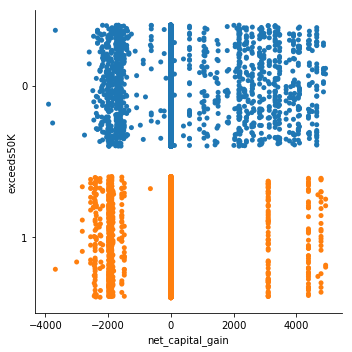

In [75]:
combined_alltrain = combined_data.loc["train",:]
combined_y_alltrain = pd.concat([combined_alltrain,
                                 y_alltrain.astype('category')], axis=1)
df = combined_y_alltrain.loc[combined_y_alltrain.net_capital_gain < 5000,:]

sns.catplot(data=df, x='net_capital_gain',
            y='exceeds50K', jitter=0.4)

# labelenc_alltrain.net_capital_gain.plot.hist(bins=100)
# plt.show()

# combined_y_alltrain.net_capital_gain[combined_y_alltrain.net_capital_gain < 5000].plot.hist(bins=30)

In [33]:
# fnlweight is not indicative of anything other than sex!
code = [12285, 13492, 13769, 1484705]
code1 = np.unique(combined_data.fnlwgt)[:10]
fnlwgt_freq = combined_data.fnlwgt.value_counts()
code2 = fnlwgt_freq.index[:3]

combined_data.loc[combined_data.fnlwgt.isin(code2),:]

age         workclass  fnlwgt     education  education-num  \
train 3312    20           Private  190290  Some-college             10   
      5988    34  Self-emp-not-inc  190290       HS-grad              9   
      7382    33         Local-gov  190290     Assoc-voc             11   
      8664    42      Self-emp-inc  120277       Masters             14   
      8880    30           Private  203488     Bachelors             13   
      10942   41           Private  120277     Bachelors             13   
      11228   40           Private  120277  Some-college             10   
      12013   30           Private  203488       HS-grad              9   
      12723   40           Private  190290  Some-college             10   
      14413   44      Self-emp-inc  120277     Assoc-voc             11   
      15996   34           Private  203488     Bachelors             13   
      16128   43           Private  120277       HS-grad              9   
      16280   30           Private  203488     Bachelors             13   
      16285   23           Private  190290     Bachelors             13   
      16713   43           Private  120277  Some-college             10   
      17350   20               NaN  190290  Some-college             10   
      17613   31           Private  203488     Bachelors             13   
      17782   32      Self-emp-inc  190290       HS-grad              9   
      17785   40           Private  120277       HS-grad              9   
      21565   41         Local-gov  120277     Bachelors             13   
      21678   33           Private  203488     Bachelors             13   
      22155   44      Self-emp-inc  120277     Bachelors             13   
      23025   43           Private  120277     Bachelors             13   
      23794   40      Self-emp-inc  190290     Bachelors             13   
test  242     31           Private  203488  Some-college             10   
      764     24           Private  190290     Assoc-voc             11   
      1296    22           Private  190290     Bachelors             13   
      2315    31           Private  203488     Bachelors             13   
      4075    31           Private  203488       HS-grad              9   
      4174    33           Private  203488     Bachelors             13   
      4271    44           Private  120277       HS-grad              9   
      4505    31           Private  203488       HS-grad              9   
      4639    31       Federal-gov  203488    Assoc-acdm             12   
      6664    34         State-gov  190290     Bachelors             13   
      7538    42           Private  190290    Assoc-acdm             12   
      8531    19           Private  120277       HS-grad              9   
      9230    34           Private  203488       HS-grad              9   
      9871    31         State-gov  203488  Some-college             10   
      11016   22               NaN  190290  Some-college             10   
      11049   33           Private  203488  Some-college             10   
      11223   33           Private  203488  Some-college             10   
      11505   41           Private  120277       HS-grad              9   
      12225   44           Private  120277       Masters             14   
      12875   23       Federal-gov  190290       HS-grad              9   
      13679   34           Private  203488  Some-college             10   
      14105   30           Private  203488  Some-college             10   
      14221   40           Private  120277     Bachelors             13   
      14674   24           Private  190290     Bachelors             13   
      16780   34  Self-emp-not-inc  203488       HS-grad              9   
      16929   20           Private  190290       HS-grad              9   
      17229   41  Self-emp-not-inc  190290       HS-grad              9   
      17673   30           Private  203488  Some-college             10   
      18541   44           Private  12

/home/dblux/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/dblux/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


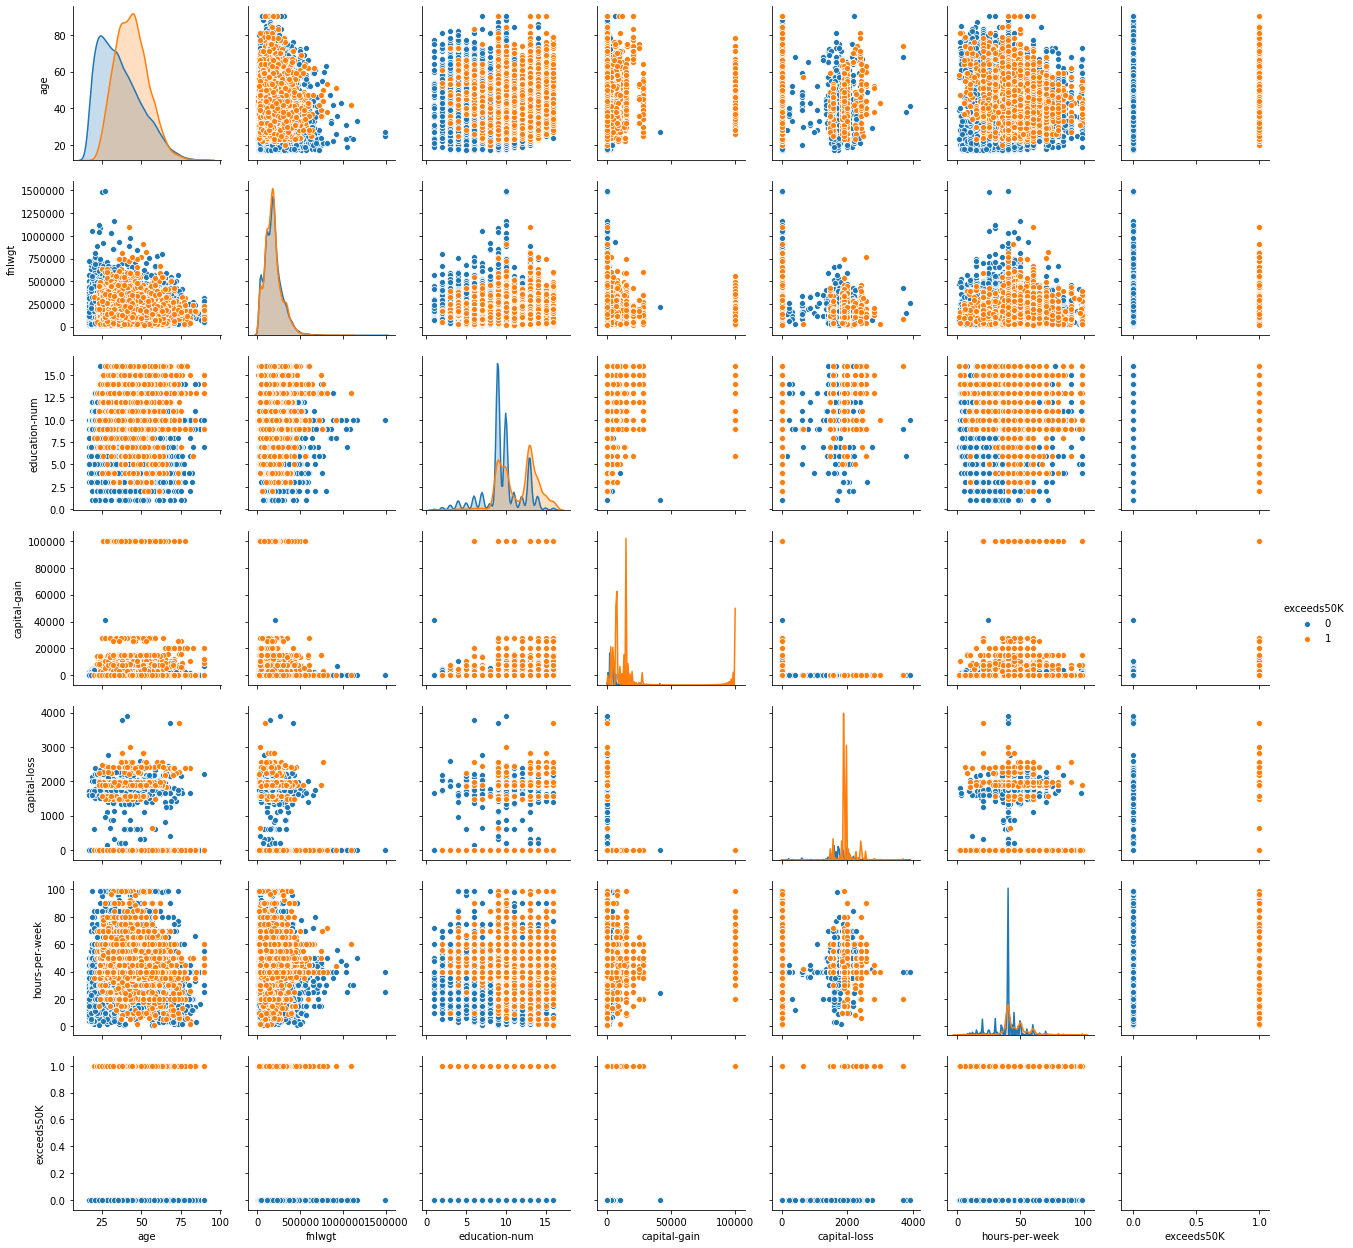

In [92]:
### Exploratory data analysis
# Pairwise plot
sns.pairplot(data_train, hue="exceeds50K")

In [ ]:
# ## Plot histogram for each feature
# fig, axes = plt.subplots(3, 3, figsize=(12,12))
# list_axes = list(iter.chain.from_iterable(axes))

# for i in range(0, pima.shape[1]):
#     pima.iloc[:,i].hist(ax = list_axes[i], bins=30)

# plt.show()

In [93]:
## Check for outliers
# Continuous attributes
print(combined_data.age.describe())
print(combined_data["hours-per-week"].describe())
print(combined_data["net_capital_gain"].describe())

# No outliers detected!

count    45170.000000
mean        38.555878
std         13.215965
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64
count    45170.000000
mean        40.942395
std         12.008316
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64
count    45170.000000
mean      1014.000908
std       7534.570243
min      -4356.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: net_capital_gain, dtype: float64


Mexico                        456
Philippines                   139
Germany                       101
Puerto-Rico                    86
El-Salvador                    82
India                          79
Canada                         75
Cuba                           69
Italy                          55
England                        55
China                          54
Jamaica                        52
Japan                          47
South                          46
Guatemala                      45
Poland                         45
Columbia                       44
Dominican-Republic             43
Vietnam                        40
Portugal                       38
Iran                           33
Haiti                          33
Taiwan                         30
Greece                         26
Nicaragua                      25
Peru                           25
Ecuador                        23
Ireland                        19
France                         19
Laos          

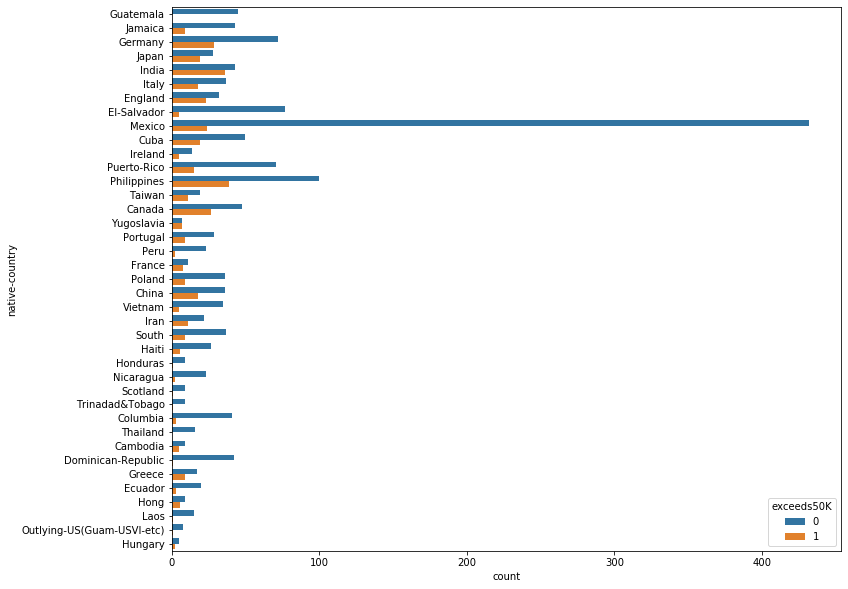

In [101]:
# Proportions
# fig, ax = plt.subplots(1,1, figsize=(12,8))
# sns.catplot(y="native-country", hue="exceeds50K", kind="count", data=data_train, ax=ax)
# sns.catplot(y="native-country", kind="count", data=train, ax=ax[1])
# sns.catplot(y="native-country", kind="count", data=X_test, ax=ax[2])

# Should we discretize native-country?
other_countries = data_train.loc[data_train["native-country"] != "United-States",
                                 ["native-country", "exceeds50K"]]

fig, ax = plt.subplots(1, 1, figsize=(12,10))
sns.countplot(y="native-country", hue="exceeds50K", data=other_countries, ax=ax)

other_countries["native-country"].value_counts()

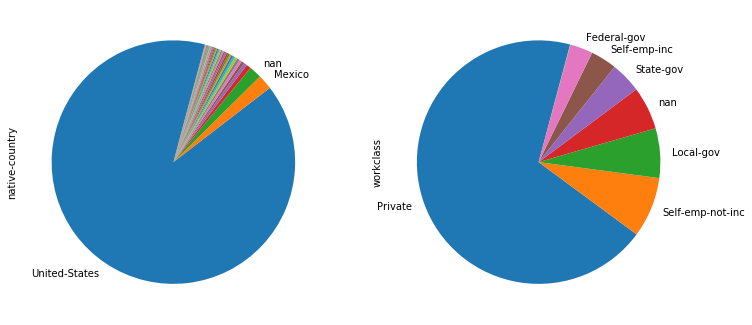

In [112]:
# combined_alltrain = combined_data.loc["train",:] # Not scaled
# combined_test = combined_data.loc["test",:]

country_alltrain = combined_alltrain['native-country'].value_counts(dropna=False)
country_labels = country_alltrain.index.tolist()
country_labels[3:] = [''] * 38

workclass_alltrain = combined_alltrain['workclass'].value_counts(dropna=False)
workclass_labels = workclass_alltrain.index.tolist()
workclass_labels[-2:] = ['', '']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
country_alltrain.plot(kind='pie', labels=country_labels,
                      startangle=75, ax=ax1)
workclass_alltrain.plot(kind='pie', labels=workclass_labels, 
                        startangle=75, ax=ax2)
plt.show()
fig.savefig('dump/fig/pie-predominant_alltrain.pdf', bbox_inches='tight')

### Dimensionality reduction

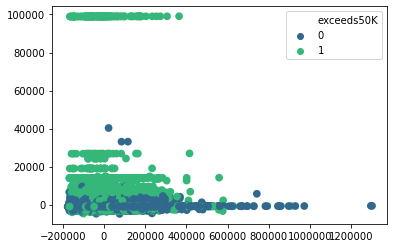

(24421, 4)
(24421, 4)


In [41]:
## PCA plots
# encoded_alltrain = encoded_data.loc["train",:] # Not scaled
# encoded_test = encoded_data.loc["test",:]

# pca = PCA(random_state=RAND_STATE, whiten=False)
# pca_alltrain = pca.fit_transform(encoded_alltrain)
# pca_test = pca.transform(encoded_test)
# var_pc = pca.explained_variance_ratio_
# print(np.cumsum(var_pc)[1:10])

fig, ax = plt.subplots(1, 1)
sns.scatterplot(pca_alltrain[:,0], pca_alltrain[:,1],
                hue=y_alltrain, palette="viridis",
                linewidth=0, s=60, legend="brief",
                ax=ax)
plt.show()
N_PC = 4
pca_data = [pca_alltrain[:,0:N_PC], pca_test[:,0:N_PC]]
print(pca_data[0].shape)
print(pca_data[1].shape)

PCA_WPATH = "dump/data/wxpp1_pca.pkl"
with open(PCA_WPATH, "wb") as f:
    pkl.dump(pca_data, f)

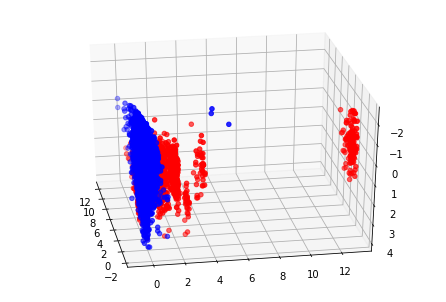

In [28]:
# Split data according to labels
pca_neg = pca_encoded[y_alltrain == 0,:]
pca_pos = pca_encoded[y_alltrain == 1,:]

# PCA: 3D
fig, ax = plt.subplots(1, 1)
ax = Axes3D(fig, elev=-150, azim=10)
ax.scatter(pca_neg[:,0], pca_neg[:,1], pca_neg[:,2], c="blue")
ax.scatter(pca_pos[:,0], pca_pos[:,1], pca_pos[:,2], c="red")
plt.show()

# fig.savefig("/home/dblux/Dropbox/pca-noscaling.png")

In [37]:
## Save PCA data!
pca = PCA(random_state=RAND_STATE)
pca_alltrain_arr = pca.fit_transform(scaled_onehotenc_alltrain)
var_pc = pca.explained_variance_ratio_
print(np.cumsum(var_pc))
pca_test_arr = pca.transform(scaled_onehotenc_test)

N_PC = 10
pca_alltrain = pd.DataFrame(pca_alltrain_arr[:,0:N_PC])
pca_test = pd.DataFrame(pca_test_arr[:,0:N_PC])
print(pca_alltrain.shape)
print(pca_test.shape)

PCA_WPATH = "dump/data/pca2.pkl"
with open(PCA_WPATH, "wb") as f:
    pkl.dump((pca_alltrain, y_alltrain, pca_test), f)

[0.2068873  0.354892   0.48333855 0.60225888 0.68595966 0.7271515
 0.75703828 0.78043439 0.80083546 0.81781937 0.83363092 0.84895679
 0.86333061 0.87582042 0.88769524 0.89864774 0.9081775  0.91646334
 0.92437693 0.93210248 0.93893271 0.94525166 0.95149001 0.95727542
 0.96217864 0.96705414 0.97144348 0.97568734 0.97960394 0.98325242
 0.98586356 0.98784228 0.98973939 0.99051156 0.9912566  0.99183715
 0.9923298  0.99280934 0.99328316 0.99373804 0.99416303 0.99454656
 0.99486965 0.99518924 0.99550021 0.99580314 0.9960894  0.9963593
 0.99662334 0.99688246 0.99713529 0.99736948 0.99759428 0.9978012
 0.99799941 0.99819394 0.99834992 0.9984946  0.99863566 0.99877097
 0.99888655 0.99899923 0.99910713 0.99920921 0.99930551 0.99939609
 0.99948093 0.99956007 0.99962476 0.99968639 0.99974773 0.99980907
 0.9998655  0.99991274 0.99995803 1.         1.         1.
 1.         1.         1.         1.         1.        ]
(24421, 10)
(24421, 10)


(24421, 80)


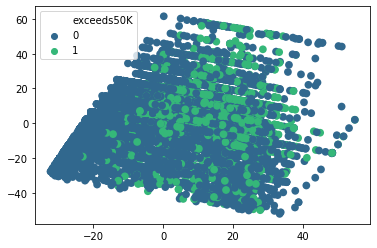

In [165]:
## PCA plots
pca = PCA(random_state=0)
pca_nocat = pca.fit_transform(encoded_nocapgain)
print(pca_nocat.shape)
var_pc = pca.explained_variance_ratio_
# print(np.cumsum(var_pc))

fig, ax = plt.subplots(1, 1)
sns.scatterplot(pca_nocat[:,0], pca_nocat[:,1],
                hue=labels, palette="viridis",
                linewidth=0, s=60, legend="brief",
                ax=ax)
plt.show()

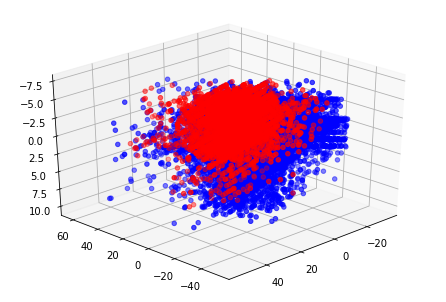

In [167]:
# Split data according to labels
pca_neg = pca_nocat[y_alltrain == 0,:]
pca_pos = pca_nocat[y_alltrain == 1,:]

# PCA: 3D
fig, ax = plt.subplots(1, 1)
ax = Axes3D(fig, elev=-150, azim=135)
ax.scatter(pca_neg[:,0], pca_neg[:,1], pca_neg[:,2], c="blue")
ax.scatter(pca_pos[:,0], pca_pos[:,1], pca_pos[:,2], c="red")
plt.show()

fig.savefig("/home/dblux/Dropbox/noscaling_nocapgain.png")

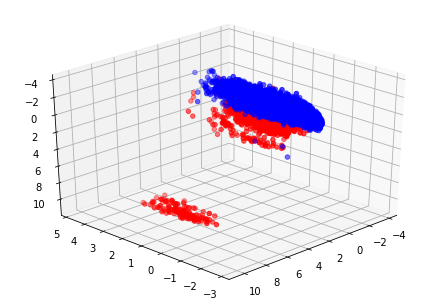

In [95]:
# Split data according to labels
pca_neg = pca_train[y_alltrain == 0,:]
pca_pos = pca_train[y_alltrain == 1,:]

# PCA: 3D
fig, ax = plt.subplots(1, 1)
ax = Axes3D(fig, elev=-150, azim=135)
ax.scatter(pca_neg[:,0], pca_neg[:,1], pca_neg[:,2], c="blue")
ax.scatter(pca_pos[:,0], pca_pos[:,1], pca_pos[:,2], c="red")
plt.show()

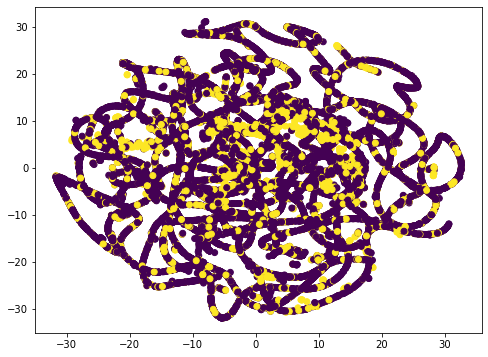

In [42]:
# TSNE visualisation
encoded_alltrain = encoded_data.loc["train",:] # Not scaled

tsne = TSNE(n_components=3, random_state=RAND_STATE, perplexity=40.0)
tsne_alltrain = tsne.fit_transform(encoded_alltrain)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(tsne_alltrain[:,0], tsne_alltrain[:,1], c=y_alltrain)
plt.show()

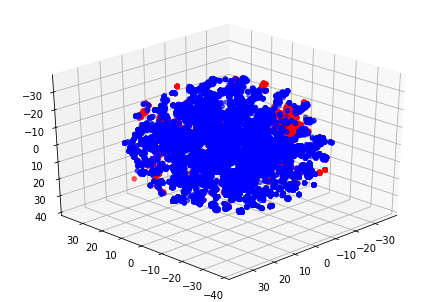

In [97]:
# Split data according to labels
tsne_neg = tsne_alltrain[y_alltrain == 0,:]
tsne_pos = tsne_alltrain[y_alltrain == 1,:]

# TSNE: 3D
fig, ax = plt.subplots(1, 1)
ax = Axes3D(fig, elev=-150, azim=135)
ax.scatter(tsne_neg[:,0], tsne_neg[:,1], tsne_neg[:,2], c="blue")
ax.scatter(tsne_pos[:,0], tsne_pos[:,1], tsne_pos[:,2], c="red")
plt.show()

### Data

| Name | Transform | Drop | NaNs | Encoding | Scaling | Model |
| :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| nopp | None | None | Replaced with 'Others' | One-hot | None | LightGBM (Native) |
| raw1 | NetCapGain | [education] | Replaced with 'Others' | None (fnlwgt: categorical) | None | CatBoost |
| raw1b | NetCapGain | [education] | Most frequent: [workclass, country] Replaced with 'Others': [occupation] | None (fnlwgt: categorical) | None | CatBoost |
| raw1c | None | None | Replaced with 'Others' | None (fnlwgt: categorical) | None | CatBoost |
| raw2a | NetCapGain | [education] | Replaced with 'Others' | One-hot | None | LightGBM/ET |
| raw2b | NetCapGain | [education] | Most frequent: [workclass, country] Replaced with 'Others': [occupation] |One-hot | None | LightGBM/ET |
| raw2c | NetCapGain | [education] | None | One-hot | None | LightGBM/ET |
| labelenc | NetCapGain | [education] | Replaced with 'Others' | Ordinal (incl. fnlwgt) | None | LightGBM |
| allcat | NetCapGain | [education-num, fnlwgt, native-country] | Replaced with 'Others' | Ordinal | Discretise [age, hours, net_capital_gain] | CategoricalNB |
| wxpp1 | NetCapGain | [education, fnlwgt, native-country] | None | One-hot | None | kNN |
| wxpp1b | NetCapGain | [education, fnlwgt, native-country] | Replaced with 'Others' | One-hot | None | kNN |
| wxpp1c | NetCapGain | [education, fnlwgt, native-country] | Most frequent: [workclass, country] Replaced with 'Others': [occupation] | One-hot | None | kNN |
| wxpp2 | NetCapGain | [education, fnlwgt, native-country] | None | One-hot | Scaling | kNN |
| pca1 | NetCapGain | [education, fnlwgt, native-country] | Most frequent: [workclass, country] Replaced with 'Others': [occupation]  | One-hot | Scaling (numeric) (PC: 10) | SVM (RBF) / MLP |
| pca2 | NetCapGain | [education, fnlwgt] | Most frequent: [workclass, country] Replaced with 'Others': [occupation] | One-hot | Scaling (numeric) (PC: 10) | SVM (RBF) / MLP |